## micro price replication 
1. symmetrize data
    - (It,St,It+1,St+1,dM) ==> (1-It,St,1-It+1,St+1,-dM)
2. Estimate Q, T, R
3. Calculate G1
4. Calculate G* ==> micro price adjustment 


In [1]:
# load libraries 
import math
import decimal 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from scipy.linalg import block_diag
from scipy.linalg import eig



In [2]:
# load data 
df_data = pd.read_csv('eth_btc_coinbase.csv.gz', compression='gzip')

# split the price and volume 
df_data[["bid_price", "bid_size"]] = df_data["bid_price_bid_size"].str.split(pat="_", expand=True).astype(float)
df_data[["ask_price", "ask_size"]] = df_data["ask_price_ask_size"].str.split(pat="_", expand=True).astype(float)

# drop original 
df_data = df_data.drop(["bid_price_bid_size", "ask_price_ask_size"], axis=1)

df_data

,time_seconds,bid_price,bid_size,ask_price,ask_size
0,1645142400,0.07137,1.863301,0.07139,0.950000
1,1645142401,0.07138,0.499840,0.07139,18.225881
2,1645142403,0.07137,0.499840,0.07139,18.225881
3,1645142404,0.07137,0.914646,0.07139,0.950000
4,1645142405,0.07137,0.499840,0.07139,18.571515
...,...,...,...,...,...
64214,1645228793,0.06950,1.549840,0.06951,3.821804
64215,1645228794,0.06950,1.549840,0.06951,3.820255
64216,1645228796,0.06950,2.221340,0.06951,2.644555
64217,1645228797,0.06950,4.066678,0.06951,2.644555


In [3]:
def processing_data(df_data, n_imb, n_spread, dt, is_filter_symm=True):
    """
    processing data for micro price construction 
    """
    
    ## 1. calculate relevant indicators 
    # find tick size 
    # minimum of absolute spread is the tick size 
    spread = df_data["ask_price"] - df_data["bid_price"]
    ticksize = np.round(min(spread.loc[spread > 0]) * 1e6) / 1e6

    # spread in terms of tick 
    df_data['spread'] = np.round((df_data['ask_price'] - df_data['bid_price']) / ticksize) * ticksize

    # mid price
    df_data['mid'] = (df_data['ask_price'] + df_data['bid_price'])/2

    # weighed mid price 
    df_data['wmid'] = (
        (df_data['ask_price'] * df_data['bid_size'] + df_data['bid_price']*df_data['ask_size'])
        / (df_data['ask_size'] + df_data['bid_size'])
    )

    # orderbook imbalance 
    df_data["imb"] = df_data["bid_size"] / (df_data["bid_size"] + df_data["ask_size"])

    # discretize imbalance into percentiles
    df_data['imb_bucket'] = pd.qcut(df_data['imb'], n_imb, labels=False)

    # next
    df_data['next_mid'] = df_data['mid'].shift(-dt)
    df_data['next_wmid'] = df_data['wmid'].shift(-dt)
    df_data['next_spread'] = df_data['spread'].shift(-dt)
    df_data['next_imb_bucket'] = df_data['imb_bucket'].shift(-dt)

    # mid price difference -- half tick 
    df_data["dM"] = np.round((df_data['next_mid'] - df_data['mid']) / ticksize * 2) * ticksize / 2
    # weighted mid price difference -- half tick 
    df_data["dwM"] = np.round((df_data['next_wmid'] - df_data['wmid']) / ticksize * 2) * ticksize / 2
    
    if is_filter_symm:
        # filter out spreads >= n_spread
        df_data = df_data.loc[(df_data["spread"] <= n_spread * ticksize)]
        # filter out dM > 1.1 * ticksize
        df_data = df_data.loc[(df_data["dM"] <= ticksize*1.1) & (df_data["dM"] >= -ticksize*1.1)]

        ## 2. symmetrize data
        #    - (It,St,It+1,St+1,dM) ==> (1-It,St,1-It+1,St+1,-dM)

        df_data_symm = df_data.copy(deep=True)
        df_data_symm['imb_bucket'] = n_imb - 1 - df_data_symm['imb_bucket']
        df_data_symm['next_imb_bucket'] = n_imb - 1 - df_data_symm['next_imb_bucket']
        df_data_symm['dM'] = -df_data_symm['dM']

        df_data = pd.concat([df_data, df_data_symm])
    
    return df_data 

In [4]:
def estimate_transi_prob(df_data, K, n_imb, n_spread):
    """
    Function to estimate transition probabiliies [Q, T, R]
    """
  
    # Q ==> transient states, 瞬时状态  [nm * nm] 
    # Xt := (It,St)
    # probability that mid_price dont change, known Xt, Xt+1

    # locate all that don't move 
    no_move = df_data[df_data['dM'] == 0]

    # count 
    # no need to use next_spread, coz mid_price not move, next_spread should stay the same 
    no_move_counts = no_move.pivot_table(index=['next_imb_bucket'], 
                                         columns=['spread', 'imb_bucket'], 
                                         values='time_seconds',
                                         fill_value=0, 
                                         aggfunc='count').unstack()

    # resize to [n * n] ==> first matrix when m=1 
    Q_counts = np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]), (n_imb,n_imb))

    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi = np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts = block_diag(Q_counts, Qi)

    # R2 ==> transient matrix, 瞬时状态 [nm * nm] ==> represents T in the paper 
    # Xt := (It,St)
    # probability that mid_price do change, known Xt, Xt+1

    # locate all that move 
    do_move = df_data[df_data['dM'] != 0]

    # count all moves 
    # 必须要对齐，index, columns 位置要正确
    move_counts = do_move.pivot_table(index=['spread', 'imb_bucket'], 
                                      columns=['next_spread', 'next_imb_bucket'], 
                                      values='time_seconds',
                                      fill_value=0, 
                                      aggfunc='count')
    # R2 = T 
    # resize to [nm * nm] 
    R2_counts = np.resize(np.array(move_counts), (n_imb*n_spread, n_imb*n_spread))

    # R ==> absorbing states, [nm * 4]
    move_counts2 = do_move.pivot_table(index=['dM'], 
                                       columns=['spread', 'imb_bucket'], 
                                       values='time_seconds',
                                       fill_value=0, 
                                       aggfunc='count').unstack()

    R_counts = np.resize(np.array(move_counts2), (n_imb*n_spread,4))
    
    # T1 = [Q_counts, R_counts]
    # combine them and calculate probability from count 
    T1 = np.concatenate((Q_counts, R_counts), axis=1).astype(float)

    # probability known Xt, Xt+1 = (count_i) / (count_dont_move + count_move)
    for i in range(0, n_imb*n_spread):
        T1[i, :] = T1[i, :] / T1[i, :].sum()

    # return Q, R1 in probability 
    Q = T1[:,0:(n_imb*n_spread)]
    R1 = T1[:,(n_imb*n_spread):]

    # T2 = [Q_counts, R2_counts]
    # combine them and calculate probability from count 
    T2 = np.concatenate((Q_counts, R2_counts), axis=1).astype(float)

    # probability known Xt, Xt+1 = (count_i) / (count_dont_move + count_move)
    for i in range(0, n_imb*n_spread):
        T2[i, :] = T2[i, :] / T2[i, :].sum()

    # return Q2, R2 in probability 
    Q2 = T2[:, 0:(n_imb*n_spread)]
    R2 = T2[:, (n_imb*n_spread):]
    
    # Calculate G1 [nm * 1]
    # G1 = (1-Q)**-1 * R * K 
    G1 = np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread) - Q), R1), K)
    
    # Calculate G* ==> micro price adjustment 
    # B = (1-Q)**-1 * R2 [nm*nm]
    B = np.dot(np.linalg.inv( np.eye(n_imb*n_spread) - Q), R2)
    
    return G1,B,Q,Q2,R1,R2

In [5]:
def f_cal_G6(G1, B):
    """
    calculate micro price 
    """
    G2=np.dot(B,G1)+G1
    G3=G2+np.dot(np.dot(B,B),G1)
    G4=G3+np.dot(np.dot(np.dot(B,B),B),G1)
    G5=G4+np.dot(np.dot(np.dot(np.dot(B,B),B),B),G1)
    G6=G5+np.dot(np.dot(np.dot(np.dot(np.dot(B,B),B),B),B),G1)
    return G6

In [6]:
# Inputs 

# number of imbalance 
n_imb = 7
# number of spread 
n_spread = 2
# delta t 
dt = 1

# grid of mid price change [half tick, one tick]
K = np.array([-0.0001, -0.00005, 0.00005, 0.0001])

In [7]:
# processing data 
df_data_to_use = processing_data(df_data, n_imb, n_spread, dt)

# estimation of transition probabiliies
G1,B,Q,Q2,R1,R2 = estimate_transi_prob(df_data_to_use, K, n_imb, n_spread)

# calculate micro price 
G6 = f_cal_G6(G1, B)


<Figure size 1040x480 with 0 Axes>

Text(0.5, 1.0, 'ETHBTC microprice adjustment')

Text(0.5, 0, 'Imbalance')

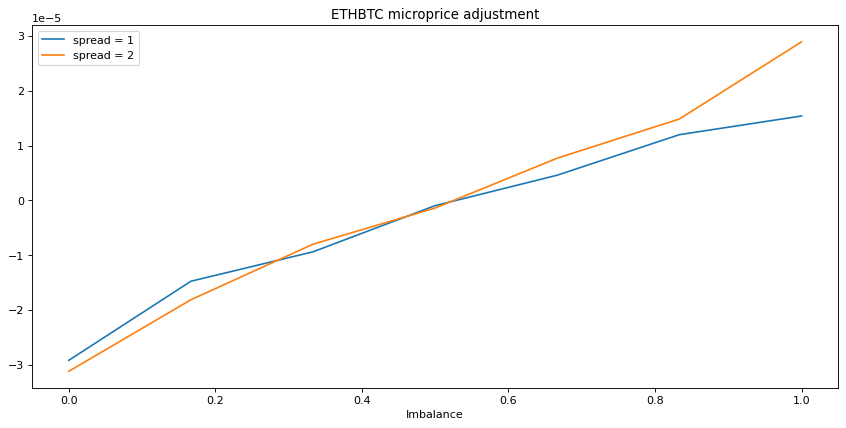

In [8]:
# plot 
imb=np.linspace(0,1,n_imb)
plt.figure(figsize=(13, 6), dpi=80)
for i in range(0,n_spread):
    plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1))
# plt.ylim(-0.005,0.005)
plt.legend(loc='upper left')
plt.title('ETHBTC microprice adjustment')
plt.xlabel('Imbalance')

### out of sample test   

In [9]:
# load test data 
df_data_test = pd.read_csv('eth_btc_coinbase_test.csv.gz', compression='gzip')

# split the price and volume 
df_data_test[["bid_price", "bid_size"]] = df_data_test["bid_price_bid_size"].str.split(pat="_", expand=True).astype(float)
df_data_test[["ask_price", "ask_size"]] = df_data_test["ask_price_ask_size"].str.split(pat="_", expand=True).astype(float)

# drop original 
df_data_test = df_data_test.drop(["bid_price_bid_size", "ask_price_ask_size"], axis=1)

# 30 seconds performance 
dt = 60

# processing data 
df_data_test_to_use = processing_data(df_data, n_imb, n_spread, dt, is_filter_symm=False)
df_data_test_to_use
print(pd.to_datetime(df_data.iloc[0,0], unit="s"))
print(pd.to_datetime(df_data_test.iloc[0,0], unit="s"))

,time_seconds,bid_price,bid_size,ask_price,ask_size,spread,mid,wmid,imb,imb_bucket,next_mid,next_wmid,next_spread,next_imb_bucket,dM,dwM
0,1645142400,0.07137,1.863301,0.07139,0.950000,0.00002,0.071380,0.071383,0.662318,4,0.07143,0.071423,0.00002,1.0,0.000050,0.000040
1,1645142401,0.07138,0.499840,0.07139,18.225881,0.00001,0.071385,0.071380,0.026693,0,0.07143,0.071424,0.00002,2.0,0.000045,0.000045
2,1645142403,0.07137,0.499840,0.07139,18.225881,0.00002,0.071380,0.071371,0.026693,0,0.07143,0.071424,0.00002,1.0,0.000050,0.000055
3,1645142404,0.07137,0.914646,0.07139,0.950000,0.00002,0.071380,0.071380,0.490520,3,0.07141,0.071419,0.00004,4.0,0.000030,0.000040
4,1645142405,0.07137,0.499840,0.07139,18.571515,0.00002,0.071380,0.071371,0.026209,0,0.07141,0.071418,0.00004,4.0,0.000030,0.000050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64214,1645228793,0.06950,1.549840,0.06951,3.821804,0.00001,0.069505,0.069503,0.288522,2,NaN,NaN,NaN,NaN,NaN,NaN
64215,1645228794,0.06950,1.549840,0.06951,3.820255,0.00001,0.069505,0.069503,0.288606,2,NaN,NaN,NaN,NaN,NaN,NaN
64216,1645228796,0.06950,2.221340,0.06951,2.644555,0.00001,0.069505,0.069505,0.456512,3,NaN,NaN,NaN,NaN,NaN,NaN
64217,1645228797,0.06950,4.066678,0.06951,2.644555,0.00001,0.069505,0.069506,0.605951,4,NaN,NaN,NaN,NaN,NaN,NaN


2022-02-18 00:00:00
2022-02-21 00:00:00


<Figure size 1040x480 with 0 Axes>

<ErrorbarContainer object of 3 artists>

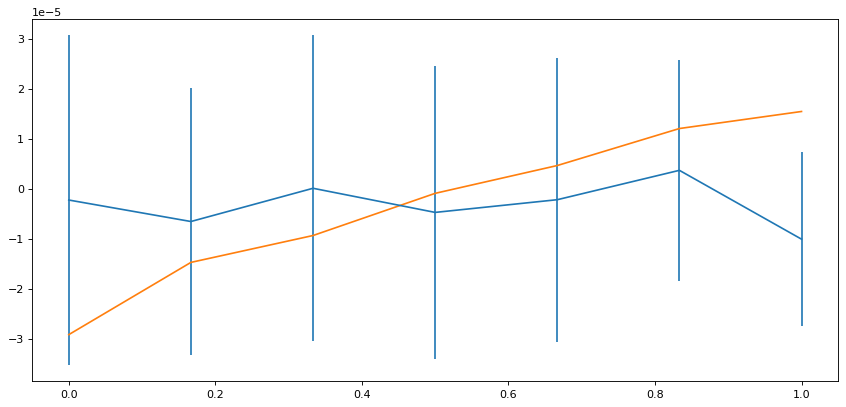

In [10]:
# out of sample test 

# find tick size 
# minimum of absolute spread is the tick size 
spread = df_data["ask_price"] - df_data["bid_price"]
ticksize = np.round(min(spread.loc[spread > 0]) * 1e6) / 1e6
    
# mid price
df_data_test['mid'] = (df_data_test['ask_price'] + df_data_test['bid_price'])/2

# change of mid price 
df_data_test['dM'] = df_data_test['mid'].shift(dt)-df_data_test['mid']

# spread in terms of tick 
df_data_test['spread'] = np.round((df_data_test['ask_price'] - df_data_test['bid_price']) / ticksize) * ticksize

# orderbook imbalance 
df_data_test["imb"] = df_data["bid_size"] / (df_data_test["bid_size"] + df_data_test["ask_size"])

# discretize imbalance into percentiles
df_data_test['imb_bucket'] = pd.qcut(df_data_test['imb'], n_imb, labels=False)

# group by spread and imb_bucket
grouped = df_data_test.groupby(['spread','imb_bucket'])
res1min = grouped['dM'].aggregate(np.mean)
std1 = grouped['dM'].aggregate(np.std)
cnt1 = grouped.count()['dM']

i=0
imb = np.linspace(0,1,n_imb)
plt.figure(figsize=(13, 6), dpi=80)
plt.errorbar(imb,
             res1min[(0+i*n_imb):(n_imb+i*n_imb)],
             yerr = np.sqrt(dt)*std1[(0+i*n_imb):(n_imb+i*n_imb)]/np.sqrt(cnt1[(0+i*n_imb):(n_imb+i*n_imb)]), 
             capthick = 5,
             label = 'empirical E[M_{t+'+str(dt)+'s}-M_t]')
plt.plot(imb,G6[(0+i*n_imb):(n_imb+i*n_imb)],label="spread = "+str(i+1))

<AxesSubplot:>

<AxesSubplot:>

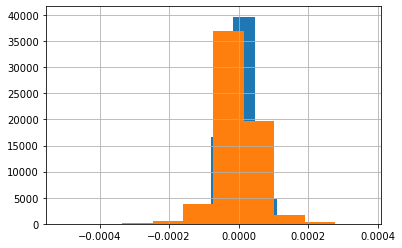

In [18]:
df_data["dM"].hist()
df_data_test["dM"].hist()

<AxesSubplot:>

<AxesSubplot:>

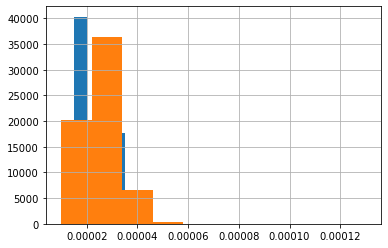

In [17]:
df_data["spread"].hist()
df_data_test["spread"].hist()

### Check the functions 
from https://github.com/shaileshkakkar/MicroPriceIndicator/blob/master/Micro-Price%20Reproduction.ipynb, 
we got the script. we check our estimations are similar compared to theirs 


In [ ]:
# Function to estimate transition probabiliies 
# from https://github.com/shaileshkakkar/MicroPriceIndicator/blob/master/Micro-Price%20Reproduction.ipynb

def estimate_old(T):
    no_move=T[T['dM']==0]
    no_move_counts=no_move.pivot_table(index=[ 'next_imb_bucket'], 
                     columns=['spread', 'imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count').unstack()

    #print no_move_counts
    Q_counts=np.resize(np.array(no_move_counts[0:(n_imb*n_imb)]),(n_imb,n_imb))
    # loop over all spreads and add block matrices
    for i in range(1,n_spread):
        Qi=np.resize(np.array(no_move_counts[(i*n_imb*n_imb):(i+1)*(n_imb*n_imb)]),(n_imb,n_imb))
        Q_counts=block_diag(Q_counts,Qi)
    #print Q_counts
    move_counts=T[(T['dM']!=0)].pivot_table(index=['dM'], 
                         columns=['spread', 'imb_bucket'], 
                         values='time',
                         fill_value=0, 
                         aggfunc='count').unstack()

    R_counts=np.resize(np.array(move_counts),(n_imb*n_spread,4))
    T1=np.concatenate((Q_counts,R_counts),axis=1).astype(float)
    for i in range(0,n_imb*n_spread):
        T1[i]=T1[i]/T1[i].sum()
    Q=T1[:,0:(n_imb*n_spread)]
    R1=T1[:,(n_imb*n_spread):]

    move_counts=T[(T['dM']!=0)].pivot_table(index=['spread','imb_bucket'], 
                     columns=['next_spread', 'next_imb_bucket'], 
                     values='time',
                     fill_value=0, 
                     aggfunc='count') #.unstack()

    R2_counts=np.resize(np.array(move_counts),(n_imb*n_spread,n_imb*n_spread))
    T2=np.concatenate((Q_counts,R2_counts),axis=1).astype(float)

    for i in range(0,n_imb*n_spread):
        T2[i]=T2[i]/T2[i].sum()
    R2=T2[:,(n_imb*n_spread):]
    Q2=T2[:,0:(n_imb*n_spread)]
    G1=np.dot(np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R1),K)
    B=np.dot(np.linalg.inv(np.eye(n_imb*n_spread)-Q),R2)
    
    return G1,B,Q,Q2,R1,R2,K

In [ ]:
# modify names 
df_T = df_data.copy(deep=True)
df_T.rename(columns={'bid_price': 'bid'}, inplace=True)
df_T.rename(columns={'ask_price': 'ask'}, inplace=True)
df_T.rename(columns={'ask_size': 'as'}, inplace=True)
df_T.rename(columns={'bid_size': 'bs'}, inplace=True)
df_T.rename(columns={'time_seconds': 'time'}, inplace=True)
df_T

In [ ]:
K = np.array([-0.01, -0.005, 0.005, 0.01])
K = np.array([-0.1, -0.05, 0.05, 0.1])

# our estimation
G1,B,Q,Q2,R1,R2, = estimate_transi_prob(df_data, K, n_imb, n_spread)

# estimation from github 
G1_,B_,Q_,Q2_,R1_,R2_,K = estimate_old(df_T)
(G1_==G1).all(),(B_ == B).all(), (Q_ == Q).all(), (R1_ == R1).all(), (R2_ == R2).all()

### Fine tuning parameters 
1. n_imbalance 
2. n_spread 
3. data time length
4. forecasting power 

In [ ]:
# 1. n_imbalance
# 2. n_spread
# 3. forecasting power

In [ ]:
n_imb_1 = 5 
n_spread_1 = 2
G1,B,Q,Q2,R1,R2, = estimate_transi_prob(processing_data(df_data, n_imb_1, n_spread_1), K, n_imb_1, n_spread_1)
G_1 = f_cal_G6(G1, B)

n_imb = 5
n_spread = 4
G1,B,Q,Q2,R1,R2, = estimate_transi_prob(processing_data(df_data, n_imb, n_spread), K, n_imb, n_spread)
G_2 = f_cal_G6(G1, B)
G_1, G_2



In [ ]:
# 1. n_imbalance

lst_n_imb = [5, 10, 20]
n_spread = 2

plt.figure(figsize=(13, 6), dpi=80)

for n_imb in lst_n_imb:
    # estimate 
    G1,B,Q,Q2,R1,R2, = estimate_transi_prob(processing_data(df_data, n_imb, n_spread), K, n_imb, n_spread)
    # micro price 
    G_1 = f_cal_G6(G1, B)
    
    # plot 
    imb = np.linspace(0,1,n_imb)
    
    for i in range(0,n_spread):
        plt.plot(imb,G_1[(0+i*n_imb):(n_imb+i*n_imb)], 
                 label="spread = " + str(i+1) + ", n_imb = " + str(n_imb))


plt.legend(loc='upper left')
plt.title('ETHBTC microprice adjustment')
plt.xlabel('Imbalance')

In [ ]:
# 2. n_spread

n_imb = 5
lst_n_spread = [2,4,6]


for n_spread in lst_n_spread:
    # estimate 
    G1,B,Q,Q2,R1,R2, = estimate_transi_prob(processing_data(df_data, n_imb, n_spread), K, n_imb, n_spread)
    # micro price 
    G_1 = f_cal_G6(G1, B)
    
    # plot 
    imb = np.linspace(0,1,n_imb)
    
    plt.figure(figsize=(13, 6), dpi=80)
    
    for i in range(0,n_spread):
        plt.plot(imb,G_1[(0+i*n_imb):(n_imb+i*n_imb)], 
                 label="spread = " + str(i+1) + ", n_spread = " + str(n_spread))
    
    plt.legend(loc='upper left')
    plt.title('ETHBTC microprice adjustment')
    plt.xlabel('Imbalance')





In [ ]:
# 3. data time length
